In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.colors as colors

import networkx as nx
import community as community_louvain

import folium
from folium.plugins import HeatMap
from folium.plugins import MarkerCluster, PolyLineTextPath
from collections import Counter

from datetime import datetime
import calendar
import holidays
import datetime

import os
import requests
from zipfile import ZipFile
from io import BytesIO

import ipywidgets as widgets
from IPython.display import display, clear_output, IFrame
import time
import asyncio

from html2image import Html2Image

### Download and open the dataset

In [2]:
base_url = "https://s3.amazonaws.com/hubway-data/"

def download_and_unzip(year, month):
    if year < 2018 or (year == 2018 and month < 5):
        brand = 'hubway'
    else:
        brand = 'bluebikes'

    filename = f"{year}{month:02d}-{brand}-tripdata.zip"
    filepath = os.path.join(f"{year}{month:02d}-{brand}-tripdata")  # replace with your local path

    # Download if the file does not exist in the device
    if not os.path.exists(filepath):
        print(f"Downloading {filename}...")
        response = requests.get(base_url + filename, stream=True)
        response.raise_for_status()
        
        # Unzip
        with ZipFile(BytesIO(response.content)) as thezip:
            print("Unzipping...")
            thezip.extractall(f"{year}{month:02d}-{brand}-tripdata") 
            print(f"Unzipped to {year}{month:02d}-{brand}-tripdata")
    else:
        print(filename,"already exists.")
    
    df_full = pd.read_csv(f"{year}{month:02d}-{brand}-tripdata/{year}{month:02d}-{brand}-tripdata.csv")
    df_full.replace('\\N', np.nan, inplace=True)
    df_full = df_full.dropna() #if the data contains NA, drop the row
    
    # Change the name of the column so that it is similar in all brand name
    if brand == 'bluebikes':
        df_full.rename(columns={'started_at': 'starttime'}, inplace=True)
        df_full.rename(columns={'ended_at': 'stoptime'}, inplace=True)
        df_full.rename(columns={'start_station_id': 'start station id'}, inplace=True)
        df_full.rename(columns={'end_station_id': 'end station id'}, inplace=True)
        df_full.rename(columns={'start_lat': 'start station latitude'}, inplace=True)
        df_full.rename(columns={'start_lng': 'start station longitude'}, inplace=True)
        df_full.rename(columns={'end_lat': 'end station latitude'}, inplace=True)
        df_full.rename(columns={'end_lng': 'end station longitude'}, inplace=True)
        df_full.rename(columns={'member_casual': 'usertype'}, inplace=True)
               
    return(df_full)

### Filter based on date and time

In [3]:
def filter_date_time(df, year, month, start_day, start_hour, start_minute, end_day, end_hour, end_minute):
    
   # Define holidays for Massachusetts, USA
    usa_holidays = holidays.UnitedStates(years=year, state='MA')
    
    # Ensure starttime and stoptime are in datetime format
    df['starttime'] = pd.to_datetime(df['starttime'])
    df['stoptime'] = pd.to_datetime(df['stoptime'])
    
    # Calculate trip duration in seconds
    if 'tripduration' not in df.columns:
        df['tripduration'] = (df['stoptime'] - df['starttime']).dt.total_seconds()
    
    # Filter trips within the specified time range
    filtered_data = df[
        (df['starttime'].dt.year == year) &
        (df['starttime'].dt.month == month) &
        (df['starttime'].dt.day >= start_day) & 
        (df['starttime'].dt.day <= end_day) &  # Ensure start and stop times fall within the same day
        (df['starttime'].dt.hour >= start_hour) &  # Starting at start_hour
        (df['starttime'].dt.minute >= start_minute) &  # Starting at or after start_minute
        (
            (df['stoptime'].dt.date == df['starttime'].dt.date) &  # Stop time is on the same day as start time
            (
                (df['starttime'].dt.hour < end_hour)   # Ending before end_hour
                # ((df['starttime'].dt.hour == end_hour-1) & (df['starttime'].dt.minute <= end_minute))  # Ending at or after end_minute
            )
        ) &
        (df['starttime'].dt.dayofweek >= 0) &  # Weekdays only
        (df['starttime'].dt.dayofweek <= 4) &  # Weekdays only
        (~df['starttime'].dt.date.isin(usa_holidays)) &
        (df['tripduration'] > 60) &  # Longer than 60 seconds
        (df['tripduration'] <= 3600)  # No longer than 3600 seconds
    ]
    
    filtered_data.reset_index(drop=True, inplace=True)
      
    return filtered_data

### Full function filtering and information extraction

In [4]:
def initial_cleaning (month, year, start_hour, end_hour, bsn_full = None):
    '''
    INPUT
    month      : Integer signify the month of analysis
    year       : Integer signify the year of analysis
    start_hour : Integer signify the start hour of analysis 
    end_hour   : Integer signify the end hour of analysis
    
    OUTPUT 
    data_filt    : Dataframe containing complete data of the trips that already filtered 
    tc           : Dataframe containing information regarding the number of trips between stations 
    stations_loc : Dataframe containing information about the latitude and longitude of each stations 
    '''
    # Download/open the file 
    if bsn_full is None:
        bsn_full = download_and_unzip(int(year), int(month))
    
    # Filter date and time 
    start_year = year
    start_month = month
    end_year = year
    end_month = month

    start_day = 1
    _, end_day = calendar.monthrange(year, month) # automatically take the last date of the month
    start_minute = 0
    end_minute = 59
    
    end_hour = end_hour

    data_filt = filter_date_time(bsn_full, year, month, start_day, start_hour, start_minute, end_day, end_hour, end_minute)
    
    # Filter self loop, member only
    data_filt = data_filt[data_filt['start station id'] != data_filt['end station id']]
    data_filt = data_filt[data_filt['usertype'].isin(['Subscriber', 'member'])]
    data_filt.reset_index(drop=True, inplace=True)
    
    # Trip_counts
    tc = data_filt.groupby(['start station id', 'end station id','start station latitude', 'start station longitude', 
                            'end station latitude', 'end station longitude']).size().reset_index(name='trip_count')
    
    # Location of the stations
    start_stations = data_filt[['start station id', 'start station latitude', 'start station longitude']].copy()
    end_stations = data_filt[['end station id', 'end station latitude', 'end station longitude']].copy()

    start_stations.columns = ['station id', 'latitude', 'longitude']
    end_stations.columns = ['station id', 'latitude', 'longitude']

    stations_loc= pd.concat([start_stations, end_stations], ignore_index=True)
    stations_loc = stations_loc.drop_duplicates(subset='station id').reset_index(drop=True)
    stations_loc['station id'] = stations_loc['station id']#.astype(int)
    stations_loc = stations_loc.sort_values(by='station id', ascending=True).reset_index(drop=True)# Delete any duplicates
    
    return data_filt, tc, stations_loc

In [5]:
def elim_stations(before_data, before_tripcount, before_stations, after_data, after_tripcount, after_stations):
    '''
    This function eliminate the stations that only exist on 2018 and not exist in 2016
    '''

    old_stations = after_stations[after_stations['station id'].isin(before_stations['station id'])]
    new_stations = after_stations[~after_stations['station id'].isin(before_stations['station id'])]
    
    data_old = after_data[
        after_data['start station id'].isin(before_stations['station id']) & 
        after_data['end station id'].isin(before_stations['station id'])
    ]
    
    tripcount_old = after_tripcount[
        after_tripcount['start station id'].isin(before_stations['station id']) & 
        after_tripcount['end station id'].isin(before_stations['station id'])
    ]

    return data_old, tripcount_old, old_stations, new_stations

In [6]:
starth = 1
endh =23
mon = 6
year1 = 2016
year2 = 2018

In [7]:
data_16, trip_counts_16, stations_loc_16 = initial_cleaning (month = mon, year = year1, start_hour = starth , end_hour = endh)

201606-hubway-tripdata.zip already exists.


In [8]:
data_18, trip_counts_18, stations_loc_18 = initial_cleaning (month = mon, year = year2, start_hour = starth , end_hour = endh)

201806-bluebikes-tripdata.zip already exists.


### Preliminary Statisical Analysis Year Before and After

In [9]:
data_18, trip_counts_18, stations_loc_18, new_stations_18 = elim_stations(data_16, trip_counts_16, stations_loc_16, data_18, trip_counts_18, stations_loc_18)

In [10]:
dif_num_trips = len(data_18) - len(data_16)
print('Different number of trips are', dif_num_trips, 'trips')

Different number of trips are 1820 trips


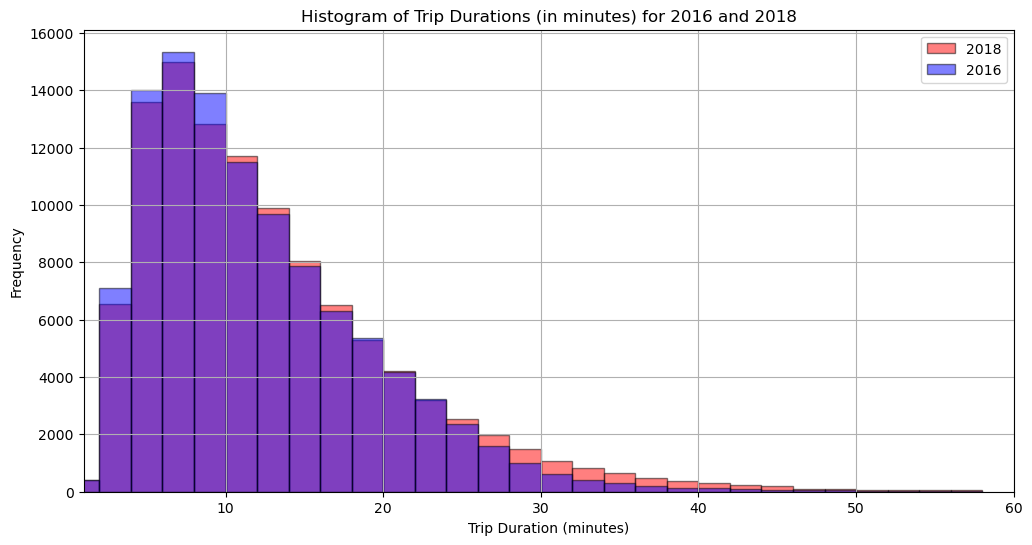

In [11]:
data_16['tripduration_minutes'] = data_16['tripduration'] / 60
data_18['tripduration_minutes'] = data_18['tripduration'] / 60

bins = range(0, 60, 2)

plt.figure(figsize=(12, 6))
plt.hist(data_18['tripduration_minutes'], bins=bins, alpha=0.5, label='2018', color='red', edgecolor='black')
plt.hist(data_16['tripduration_minutes'], bins=bins, alpha=0.5, label='2016', color='blue', edgecolor='black')
plt.title('Histogram of Trip Durations (in minutes) for 2016 and 2018')
plt.xlabel('Trip Duration (minutes)')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.xlim(1,60)
plt.grid(True)
plt.show()

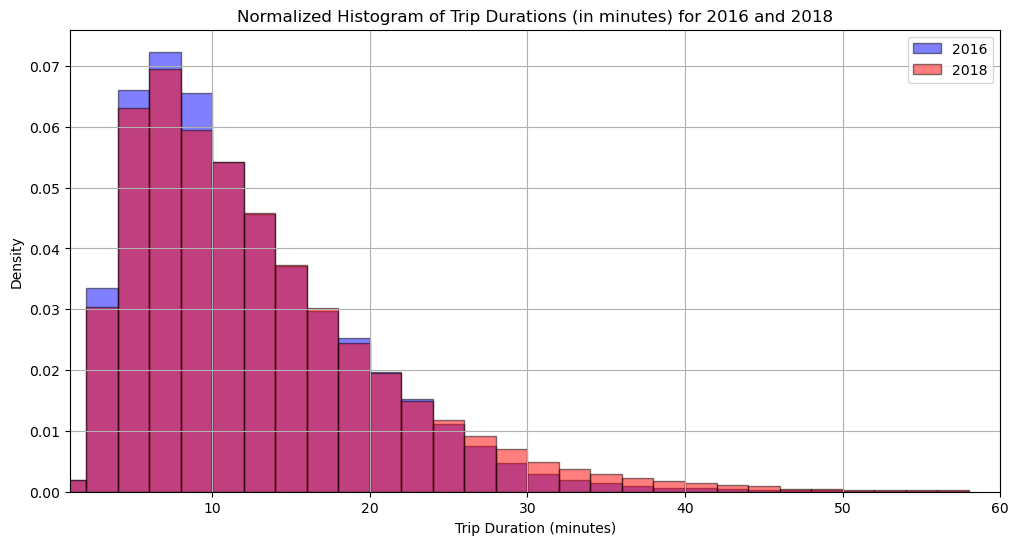

In [12]:
data_16['tripduration_minutes'] = data_16['tripduration'] / 60
data_18['tripduration_minutes'] = data_18['tripduration'] / 60

bins = range(0, 60, 2)

# Plot normalized
plt.figure(figsize=(12, 6))
hist_16, bins_16, _ = plt.hist(data_16['tripduration_minutes'], bins=bins, alpha=0.5, label='2016', color='blue', edgecolor='black', density=True)
hist_18, bins_18, _ = plt.hist(data_18['tripduration_minutes'], bins=bins, alpha=0.5, label='2018', color='red', edgecolor='black', density=True)
plt.title('Normalized Histogram of Trip Durations (in minutes) for 2016 and 2018')
plt.xlabel('Trip Duration (minutes)')
plt.ylabel('Density')
plt.legend(loc='upper right')
plt.grid(True)
plt.xlim(1, 60)
plt.show()

In [13]:
map_center = [new_stations_18['latitude'].mean(), new_stations_18['longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=11, tiles='CartoDB positron')

# Add markers for each new station
for _, station in new_stations_18.iterrows():

    folium.CircleMarker(
            location=[station['latitude'], station['longitude']],
            radius=3,
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=0.7,
             popup=f"Station ID: {station['station id']}"
        ).add_to(m)

for _, station in stations_loc_18.iterrows():

    folium.CircleMarker(
            location=[station['latitude'], station['longitude']],
            radius=3,
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.7,
            popup=f"Station ID: {station['station id']}"
        ).add_to(m)

legend_html = f'''
     <div style="position: fixed; 
                 top: 10px; right: 20px; width: 150px; height: 80px; 
                 background-color: white; border:2px solid grey; z-index:9999; font-size:14px;
                 ">
     &nbsp; <b>Legend</b> <br>
     &nbsp; <i class="fa fa-circle" style="color:red"></i>&nbsp; New Stations <br>
     &nbsp; <i class="fa fa-circle" style="color:blue"></i>&nbsp; Old Stations
     </div>
     '''

m.get_root().html.add_child(folium.Element(legend_html))
m

### Network of the Bike Sharing

In [79]:
def create_network(trip_count_df, stations_locs, plot=False):
    '''
    INPUT 
    trip_count_df  : Dataframe containing the start station, end station, and trip count 
    stations_locs  : Dataframe containing the stations and its location coordinates
    
    OUPUT
    BSN     : Bidirectional graph 
    UNDIR   : Undirected graph
    adj_df  : Dataframe of the adjacency matrix of the bidirectional graph
    '''
    # Create Bidirectional graph
    BSN = nx.DiGraph()

    # Add edges for everytrip between the nodes(stations)
    for _, row in trip_count_df.iterrows():
        BSN.add_edge((row['start station id']), (row['end station id']), weight=(row['trip_count']))
        
    # Calculate the adjacency matrix
    adj_mat = nx.adjacency_matrix(BSN)
    # Reformating to pandas dataframe
    adj_df = pd.DataFrame(adj_mat.todense().astype(int), index=BSN.nodes(), columns=BSN.nodes()) 
    
    # Create the undirected network with the edges only register if exist both direction and the weight is the sum of both weights
    UNDIR = nx.Graph()
    for u, v, data in BSN.edges(data=True):
        
        #### Normal Undirected
        if UNDIR.has_edge(u, v):
            # If the edge already exists in the undirected graph, add the weight
            UNDIR[u][v]['weight'] += data['weight']
        else:
            # If the edge doesn't exist, create it with the current weight
            UNDIR.add_edge(u, v, weight=data['weight'])
    
    if plot == True:
        plt.figure(figsize=(17, 17)) 

        # pos = nx.kamada_kawai_layout(BSN)  # layout option 1
        pos = {row['station id']: (row['longitude'], row['latitude']) for idx, row in stations_locs.iterrows()} #layout based on coordinates
        # nx.draw(BSN, pos, with_labels=True, node_size=500, node_color='lightblue', arrows=True, edge_color='grey', alpha=1)
        nx.draw_networkx_nodes(BSN, pos, node_size=500, node_color='lightblue')
        nx.draw_networkx_edges(BSN, pos, edge_color='grey', arrows=True, alpha=0.2)
        # nx.draw_networkx_labels(BSN, pos)

        plt.axis('off')
        plt.title('Network of the Bike Sharing')

        plt.show()
    
    return BSN, UNDIR, adj_df      

In [80]:
BSN16, UNDIR16, adj16 = create_network(trip_counts_16, stations_loc_16, plot=False)
BSN18, UNDIR18, adj18 = create_network(trip_counts_18, stations_loc_18, plot=False)

In [81]:
print("Sanity check if the number of trip after data in the adjacency matrix match of that in the trips database:", adj16.sum().sum() == len(data_16))
print("Sanity check if the number of trip before data in the adjacency matrix match of that in the trips database:", adj18.sum().sum() == len(data_18))

Sanity check if the number of trip after data in the adjacency matrix match of that in the trips database: True
Sanity check if the number of trip before data in the adjacency matrix match of that in the trips database: True


## Analysis 1 -- Community Comparison

#### Create Community - Louvain Algorithm

First, find the communities using the Louvain algorithm

Threshold : stopping criterion 
           If moving a node results in a modularity gain that is smaller than the threshold, 
           the algorithm concludes that it cannot meaningfully increase the modularity by further moves.
           When the modularity gain across all nodes is below this threshold, the algorithm stops.

Resolution : If resolution is less than 1, the algorithm favors larger communities. Greater than 1 favors smaller communities

In [143]:
# Function to find the best resolutions 
def com_finder (network,resolutions_range, plot=False):
    
    '''
    INPUT 
    network           : NetworkX format of Network 
    resolutions_range : List of possible values of resolution
    
    OUTPUT
    best_mod     : Value of the highest modularity 
    best_res     : Best resolution that produce best modularity
    commmunities : The list of nodes of communities 
    '''

    modularity_scores = []

    for res in resolutions_range:
        coms = nx.community.louvain_communities(network, weight='weight', resolution=res, threshold=1e-8, seed=123123)
        modularity = nx.community.modularity(network, coms, weight='weight')
        modularity_scores.append(modularity)
        
    best_mod = np.max(modularity_scores)
    best_res = resolutions_range[np.argmax(modularity_scores)]
    # print("Best resolution is on", best_res, "with the value of modularity is", np.round(best_mod,2))
    
    communities = nx.community.louvain_communities(network, weight='weight',resolution=best_res, threshold=1e-8, seed=123123)
        
    if plot:    
        plt.figure(figsize=(10, 5))
        plt.plot(resolutions_range, modularity_scores, marker='o', color='red')
        plt.title('Modularity vs. Resolution')
        plt.xlabel('Resolution')
        plt.ylabel('Modularity Score')
        plt.grid(True)
        plt.show()
        
    return best_mod, best_res, communities

In [144]:
# bmod16, bres16, commun16 = com_finder(BSN16, resolutions_range = [0.2,0.5,0.8,0.9,1,1.1,1.2,1.5,1.8], plot=True)
bmod16, bres16, commun16 = com_finder(BSN16, resolutions_range = [1], plot=False)

In [145]:
# bmod18, bres18, commun18 = com_finder(BSN18, resolutions_range = [0.2,0.5,0.8,0.9,1,1.1,1.2,1.5,1.8], plot=True)
bmod18, bres18, commun18 = com_finder(BSN18, resolutions_range = [1], plot=False)

## Plotting of the communities and heatmap

In [20]:
# Coordinates of Cambridge Street and Oxford Street 
cam_str = [(42.373918, -71.102282),(42.374924, -71.110130),(42.375454, -71.114163)]
ox_str = [(42.386056, -71.116185),(42.385192, -71.116162),(42.384312, -71.116105),(42.383633, -71.116101),(42.378770, -71.116624),(42.376446, -71.115758)]

In [21]:
colors = ['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'pink', 'gray', 'brown', 'cyan',
     'magenta', 'lime', 'maroon', 'olive', 'navy', 'teal', 'aqua', 'fuchsia', 'silver'
]

# colors = ['cyan', 'lime', 'olive', 'navy', 'teal', 'aqua', 'fuchsia', 'silver', 'brown']

In [22]:
def create_community_color_df(communities, colors):
    """
    INPUT
    communities : Each set contains the node IDs of a community.
    colors      : List of strings containing the colors to assign to each community.

    OUPUT
    community_color_df : DataFrame with columns containing the nodes, the community they belong, and the color associated
    """
    sorted_communities = sorted(communities, key=lambda x: min(x))
    
    community_color_data = []
    for idx, community in enumerate(sorted_communities):
        color = colors[idx % len(colors)]
        for node in sorted(community):
            community_color_data.append((node, idx, color))
    
    community_color_df = pd.DataFrame(community_color_data, columns=['Node', 'Community', 'Color'])
    
    if pd.api.types.is_float_dtype(community_color_df['Node']):
        community_color_df['Node'] = community_color_df['Node'].astype(int)  
    
    return community_color_df

In [208]:
def plot_community(communities, stations_locs_df, zoom, month, year, time, central_node):
    '''
    INPUT
    communities        : List of sets containing stations that are grouped based on the communities
    stations_locs_df   : DataFrame containing the stations and their location coordinates
    zoom               : Initial zoom level for the map
    month              : Month for the analysis
    year               : Year for the analysis
    time               : Time for the analysis
    central_node       : Station ID of the central node to be highlighted

    OUTPUT
    community_color_df : DataFrame mapping each node to its community and color
    map_boston         : Folium map object with plotted stations and their communities
    '''

    map_center_latitude = stations_locs_df['latitude'].mean()
    map_center_longitude = stations_locs_df['longitude'].mean()

    # Use the function to create the community color DataFrame if the input is not already the processed DataFrame 
    if isinstance(communities, pd.DataFrame):
        community_color_df = communities 
    else:
        community_color_df = create_community_color_df(communities, colors)  
    
    node_to_color = community_color_df.set_index('Node')['Color'].to_dict()

    # Create the map
    map_boston = folium.Map(location=[map_center_latitude, map_center_longitude], tiles='CartoDB positron', zoom_start=zoom)

    folium.PolyLine(cam_str, color='blue', weight=4, opacity=1).add_to(map_boston)
    folium.PolyLine(ox_str, color='olive', weight=4, opacity=1).add_to(map_boston)

    the_existence = False

    # Plot the stations, colored by community
    for _, row in stations_locs_df.iterrows():
        station_id = row['station id']
        station_coords = [row['latitude'], row['longitude']]
        station_color = node_to_color.get(station_id, "white")
        
        # Determine the border color
        if station_id == central_node:
            border_color = "teal"
        else:
            border_color = station_color

        if station_id == 109:
            lat_offset = 0.001 
            lon_offset = -0.001  
            station_coords = [station_coords[0] + lat_offset, station_coords[1] + lon_offset]  
            folium.CircleMarker(
                location=station_coords,
                popup=f'Station ID: {station_id}',
                radius=5,
                color=border_color,
                fill=True,
                fill_color=station_color,
                fill_opacity=0.7
            ).add_to(map_boston)

            
        folium.CircleMarker(
            location=station_coords,
            popup=f'Station ID: {station_id}',
            radius=5,
            color=border_color,
            fill=True,
            fill_color=station_color,
            fill_opacity=0.7
        ).add_to(map_boston)

    # Stations Markers
    stations = [
        (42.3770, -71.1167, 'Harvard Square Station'),
        (42.388505, -71.119198, 'Porter Square Station'),
        (42.365338, -71.103418, 'Central Station'),
        (42.362400, -71.085570, 'Kendall/MIT Station'),
        (42.395579, -71.142624, 'Alewife Station'),
        (42.356331, -71.062290, 'Park Street Station')
    ]

    for lat, lon, name in stations:
        folium.CircleMarker(location=[lat, lon], radius=6, popup=name,
                            color='black', fill=True, fill_color='grey', fill_opacity=1).add_to(map_boston)

    month_name = datetime.date(year, month, 1).strftime('%b')
    formatted_time = f"{time:02}:00"
    formatted_string = f"{month_name} {year}, {formatted_time}"

    legend_html = f'''
    <div style="position: fixed; 
                top: 30px; right: 50px; width: 170px; height: 40px; 
                border:3px solid grey; z-index:9999; font-size:20px;
                ">&nbsp;{formatted_string}
    </div>
    '''
    map_boston.get_root().html.add_child(folium.Element(legend_html))

    return community_color_df, map_boston

In [24]:
def plot_heatmap(direction_df, trip_df1, trip_df2, location_df, month, year, time, zoom):
    '''
    INPUT
    stations_locs_df   : DataFrame containing the stations and their location coordinates
    zoom 
    month
    year
    time
    direction_df
    df_trip 
    
    OUTPUT
    map_boston         : Folium map object with plotted stations and their communities
    
    '''  


    map_center_latitude = location_df.iloc[:,1].mean()
    map_center_longitude = location_df.iloc[:,2].mean()

    map_boston = folium.Map(location=[map_center_latitude, map_center_longitude], tiles='CartoDB positron', zoom_start=zoom)

    marker_cluster = MarkerCluster().add_to(map_boston)
    color = ["purple","orange"]

    for i in range(2):
        trip_df = trip_df1 if i == 0 else trip_df2 
        if trip_df.empty:
            continue
        max_weight = max(trip_df['trip_count'])
        min_weight = min(trip_df['trip_count'])
        
        for idx, row in trip_df.iterrows():
            start_coords = [row['start station latitude'], row['start station longitude']]
            end_coords = [row['end station latitude'], row['end station longitude']]
            
            folium.CircleMarker(
                location=start_coords,
                radius=5,
                popup=f"Start Station ID: {row['start station id']}",
                color='red',
                fill=True,
                fill_color='red',
                fill_opacity=0.7,
            ).add_to(map_boston)

            folium.CircleMarker(
                location=end_coords,
                radius=5,
                popup=f"End Station ID: {row['end station id']}",
                color='red',
                fill=True,
                fill_color='red',
                fill_opacity=0.7,
            ).add_to(map_boston)

        
            # Lines represents the bike trip 
            line = folium.PolyLine(
                locations=[start_coords, end_coords],
                color='transparent',  # Make the line color transparent
                weight=0.5  # Thin line just to place the arrow
            ).add_to(map_boston)
    
            # Add directional arrows with the line weight based on the trip count
            line_weight = 1 + 4 * (row['trip_count'] - min_weight) / (max_weight - min_weight) if max_weight > min_weight else 1
            arrow = PolyLineTextPath(
                line,
                '→',  # Use '→' or any arrow symbol
                repeat=True,
                offset=0,
                attributes={'fill': color[i], 'font-weight': 'bold', 'font-size': f'{line_weight * 5}px'}  # Adjust font size based on weight
            )
            map_boston.add_child(arrow)    
        

    for idx, row in direction_df.iterrows():
        for _ in range(int(row.iloc[3])):
            folium.Marker(
                location=[row.iloc[1], row.iloc[2]],
                icon=folium.Icon(color='red', icon_size=(0, 0), icon_anchor=(0, 0))
            ).add_to(marker_cluster)

    # for idx, row in direction_df.iterrows():
    #     folium.Marker(
    #         location=[row.iloc[1], row.iloc[2]],  
    #         icon=folium.DivIcon(
    #             icon_size=(150, 36),
    #             icon_anchor=(15, 0),
    #             offset = 10,
    #             html=f'<div style="font-size: 12pt; color: blue;">{row.iloc[3]}</div>',  # Assuming column 3 has the counts or text to display
    #         ),
    #     ).add_to(map_boston)
                
    
    # Heatmap
    heat_data = [[row.iloc[1], row.iloc[2], row.iloc[3]] for index, row in direction_df.iterrows()]
    heatmap = HeatMap(heat_data)
    map_boston.add_child(heatmap)


    folium.PolyLine(cam_str, color='blue', weight=5, opacity=1).add_to(map_boston)
    # folium.PolyLine(ox_str, color='olive', weight=5, opacity=1).add_to(map_boston)

    
    # Stations Markers
    stations = [
        (42.3770, -71.1167, 'Harvard Square Station'),
        (42.388505, -71.119198, 'Porter Square Station'),
        (42.365338, -71.103418, 'Central Station'),
        (42.362400, -71.085570, 'Kendall/MIT Station'),
        (42.395579, -71.142624, 'Alewife Station'),
        (42.356331, -71.062290, 'Park Street Station')
    ]

    for lat, lon, name in stations:
        folium.CircleMarker(location=[lat, lon], radius=6, popup=name,
                            color='black', fill=True, fill_color='grey', fill_opacity=1).add_to(map_boston)

    month_name = datetime.date(year, month, 1).strftime('%b')
    formatted_time = f"{time:02}:00"
    formatted_string = f"{month_name} {year}, {formatted_time}"

    legend_html = f'''

    <div style="position: fixed; 
                top: 30px; right: 50px; width: 170px; height: 40px; 
                border:3px solid grey; z-index:9999; font-size:20px;
                ">&nbsp;{formatted_string}
    </div>

    
    '''
    map_boston.get_root().html.add_child(folium.Element(legend_html))

    return map_boston

## Partial Functions

In [25]:
def the_spots(coordinate, num_stats, stations_loc):
    '''
    INPUT
    coordinate   : Array of (latitude,longitude)
    num_stats    : Integer corresponds to the number of stations closest to the target streets
    stations_loc : Dataframe containing the stations and its location coordinates
    
    OUTPUT 
    stationz = the name of the closest stations to the coordinnate
    '''
    d1 = np.array([stations_loc['latitude'], stations_loc['longitude']]).T - coordinate.reshape(1, 2)
    dst = np.linalg.norm(d1, axis=1)
    idx_closest = np.argsort(dst)[:num_stats]
    stationz = stations_loc.iloc[idx_closest]['station id'].tolist()
            
    return stationz

In [26]:
def partial_graph_data(closest_stations, trip_counts_df, station_locs_df, data_df):
    '''
    INPUT
    closest_stations   : List or list of lists of closest stations to the target street
    trip_count_df      : Dataframe containing the start station, end station, and trip count 
    stations_loc       : Dataframe containing information about the latitude and longitude of each stations 
    data_df            : DataFrame full information about the bike trip


    OUTPUT 
    trips_spot           : Dataframe containing the information regarding the trips between the closest stations
    stations_loc_partial : Dataframe containing the information about the latitude and longitude of each closest stations 
    partial              : Directed graph of the closest stations
    '''
    
    if isinstance(closest_stations[0], list):
        # Handle input as list of lists
        set1 = set(closest_stations[0])
        set2 = set(closest_stations[1])
        
        # Filter trips between set1 and set2 (or reverse)
        trips_spot = trip_counts_df[
            ((trip_counts_df['start station id'].isin(set1)) & (trip_counts_df['end station id'].isin(set2))) |
            ((trip_counts_df['start station id'].isin(set2)) & (trip_counts_df['end station id'].isin(set1)))
        ].reset_index(drop=True)

        data_spot = data_df[
            ((data_df['start station id'].isin(set1)) & (data_df['end station id'].isin(set2))) |
            ((data_df['start station id'].isin(set2)) & (data_df['end station id'].isin(set1)))
        ].reset_index(drop=True)
        
        # Filter station locations
        filtered_stations = set1.union(set2)
        stat_loc_spot = station_locs_df[station_locs_df['station id'].isin(filtered_stations)].reset_index(drop=True)
    else:
        # Handle input as a single list
        trips_spot = trip_counts_df[
            (trip_counts_df['start station id'].isin(closest_stations)) & 
            (trip_counts_df['end station id'].isin(closest_stations))
        ].reset_index(drop=True)

        data_spot = data_df[
            ((data_df['start station id'].isin(closest_stations)) & (data_df['end station id'].isin(closest_stations)))
        ].reset_index(drop=True)
        
        # Filter station locations
        stat_loc_spot = station_locs_df[station_locs_df['station id'].isin(closest_stations)].reset_index(drop=True)
    
    # Make the graph
    partial = nx.DiGraph()
    for _, row in trips_spot.iterrows():
        partial.add_edge(row['start station id'], row['end station id'], weight=row['trip_count'])
            
    return trips_spot, stat_loc_spot, data_spot, partial

## Testing

In [27]:
def jaccard_index(set1, set2):
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    if not union:
        return 0.0
    return len(intersection) / len(union)

In [28]:
def geometric_median(coords):
    """
    Compute the geometric median of a numpy array of coordinates.
    """
    def L1_norm(x):
        return np.sum(np.linalg.norm(coords - x, axis=1))

    # Initial guess: simply use the mean
    initial_guess = np.mean(coords, axis=0)

    result = minimize(L1_norm, initial_guess, method='BFGS')
    return result.x

def calculate_center_of_mass(df):
    """ Calculate the geometric center for each community based on longitude and latitude. """
    centroids = df.groupby('Community').apply(
        lambda g: geometric_median(g[['longitude', 'latitude']].values),
        include_groups=False  # Add this parameter to comply with future pandas updates
    )
    return centroids.to_dict()


def find_closest_anchor(center_of_mass, anchors):
    """ Find the closest anchor to a given center of mass. """
    closest = min(anchors, key=lambda x: np.linalg.norm(np.array(center_of_mass) - np.array((x['Longitude'], x['Latitude']))))
    return closest['Community'], closest['Color']

def assign_colors_based_on_proximity(centroids, anchors, available_colors):
    # Step 1: Calculate distances from each community to each anchor
    distances = {}
    for comm, center in centroids.items():
        for anchor_id, anchor_details in anchors.items():
            if comm not in distances:
                distances[comm] = {}
            distances[comm][anchor_id] = np.linalg.norm(np.array(center) - np.array((anchor_details['Longitude'], anchor_details['Latitude'])))

    # Step 2: Determine the closest community for each anchor
    closest_communities = {}
    for anchor_id in anchors:
        closest_community = min(distances, key=lambda x: distances[x][anchor_id])
        closest_communities[closest_community] = anchor_id

    # Step 3: Assign anchor colors to closest communities and other colors to the rest
    color_mapping = {}
    used_colors = set()
    for comm, anchor_id in closest_communities.items():
        anchor_color = anchors[anchor_id]['Color']
        color_mapping[comm] = anchor_color
        used_colors.add(anchor_color)

    # Ensure unique colors for other communities
    remaining_colors = [color for color in available_colors if color not in used_colors]
    color_iter = iter(remaining_colors)
    for comm in centroids:
        if comm not in color_mapping:
            try:
                color_mapping[comm] = next(color_iter)
            except StopIteration:
                # Reset iterator if there are more communities than remaining colors
                color_iter = iter(remaining_colors)
                color_mapping[comm] = next(color_iter)

    return color_mapping
    
def enhanced_color_assignment(previous_df, current_df, available_colors, anchors):

    previous_communities = {k: set(g['Node']) for k, g in previous_df.groupby('Community')}
    current_communities = {k: set(g['Node']) for k, g in current_df.groupby('Community')}
    community_sizes = {k: len(v) for k, v in current_communities.items()}
    
    mapping = {}
    jaccard_scores = {}
    for current, current_set in current_communities.items():
        best_match = None
        highest_jaccard = 0
        for previous, previous_set in previous_communities.items():
            j_index = jaccard_index(current_set, previous_set)
            if j_index > highest_jaccard:
                highest_jaccard = j_index
                best_match = previous
        mapping[current] = best_match
        jaccard_scores[current] = highest_jaccard

    reverse_mapping = {prev: [] for prev in previous_communities.keys()}
    for cur, prev in mapping.items():
        if prev is not None:
            reverse_mapping[prev].append(cur)

    # Calculate centers of mass
    previous_centroids = calculate_center_of_mass(previous_df)
    current_centroids = calculate_center_of_mass(current_df)
    
    color_mapping = {}
    used_colors = set(previous_df['Color'])
    available_color_iter = iter(available_colors)

    for prev, cur_list in reverse_mapping.items():
        color_mapping.update(assign_colors_based_on_proximity(current_centroids, anchors, available_colors))

    # Assign new colors to new communities or unassigned communities
    for cur in current_communities.keys():
        if cur not in color_mapping:
            color_mapping[cur] = next(available_color_iter, 'Fallback Color')

    current_df['Color'] = current_df['Community'].map(color_mapping)

    return current_df

In [29]:
def update_available_colors(previous_df):
    # all_colors = [
    #     'red', 'blue', 'green', 'yellow', 'purple', 'orange', 'pink', 'gray', 'brown', 'cyan',
    #     'magenta', 'lime', 'maroon', 'olive', 'navy', 'teal', 'aqua', 'fuchsia', 'silver'
    # ]
    all_colors = [ 'yellow', 'lime', 'cyan','magenta', 'brown', 'maroon', 'navy', 'aqua', 'fuchsia']
    used_colors = set(previous_df['Color'])
    available_colors = [color for color in all_colors if color not in used_colors]
    return available_colors

In [122]:
anchors = {
    1: {'Longitude': -71.095993,
        'Latitude': 42.360839,
        'Color': 'red',
        'Community': int(0)  
    },
    2: {
        'Longitude':  -71.116865,
        'Latitude': 42.377945,
        'Color': 'green',
        'Community': int(1) 
    },

        3: {
        'Longitude': -71.126533,
        'Latitude': 42.402038,
        'Color': 'purple',
        'Community': int(2) 
    },

        4: {
        'Longitude': -71.069616,
        'Latitude': 42.345392,
        'Color': 'blue',
        'Community': int(3) 
    },    

        5: {
        'Longitude': -71.105221,
        'Latitude': 42.334073,
        'Color': 'orange',
        'Community': int(4) 
    }
}

In [31]:
all_colors = [ 'red', 'blue', 'green', 'yellow', 'purple', 'orange', 'pink', 'gray', 'brown', 'cyan',
                'magenta', 'lime', 'maroon', 'olive', 'navy', 'aqua', 'fuchsia']

## Heatmap

In [32]:
def process_duration_data(data_afr, hour, month, year):
    
    # Median because it might be better in the case of skewed distribution
    tda = data_afr.groupby(['start station id', 'end station id'])['tripduration'].median().reset_index().astype(int)
    tda.rename(columns={'tripduration': 'median duration'}, inplace=True)

    tda['hour'] = hour
    tda['month'] = month
    tda['year'] = year
    
    return tda

In [33]:
def filter_partial(closest_stations, trip_counts_df, station_locs_df, data_df):
    
    # Handle input as list of lists
    set1 = set(closest_stations[0])
    set2 = set(closest_stations[1])
    
    # Filter trips between set1 and set2 (or reverse)
    trips_spot_1 = trip_counts_df[(trip_counts_df['start station id'].isin(set1)) & (trip_counts_df['end station id'].isin(set2))].reset_index(drop=True)
    trips_spot_2 = trip_counts_df[(trip_counts_df['start station id'].isin(set2)) & (trip_counts_df['end station id'].isin(set1))].reset_index(drop=True)


    data_spot_1 = data_df[(data_df['start station id'].isin(set1)) & (data_df['end station id'].isin(set2))].reset_index(drop=True)
    data_spot_2 = data_df[(data_df['start station id'].isin(set2)) & (data_df['end station id'].isin(set1))].reset_index(drop=True)

    # Filter station locations
    filtered_stations = set1.union(set2)
    stat_loc_spot = station_locs_df[station_locs_df['station id'].isin(filtered_stations)].reset_index(drop=True)
    
    return trips_spot_1, trips_spot_2, data_spot_1, data_spot_2, stat_loc_spot

In [34]:
def generate_heatmaps(years, months, hours, zoom_size, points_side_1, points_side_2, target, depart=True):
    maps = {}
    combined_data = pd.DataFrame()
    target_df = pd.DataFrame()

    for yy in years:
        for mm in months:
            bsn = download_and_unzip(int(yy), int(mm))

            for hour in hours:
                # Generate data for each hour
                data_total, trip_counts_total, stations_loc_total = initial_cleaning(month=mm, year=yy, start_hour=hour, end_hour=hour+1, bsn_full=bsn)
                
                tdf = trip_counts_total.loc[(trip_counts_total['start station id'].isin(target)) | 
                            (trip_counts_total['end station id'].isin(target))].copy()
                tdf['hour'] = hour
                tdf['month'] = mm
                tdf['year'] = yy
                target_df = pd.concat([target_df, tdf], ignore_index=True)  

                closest_stations=[points_side_1, points_side_2]
                tc1, tc2, d1, d2, sloc = filter_partial(closest_stations, trip_counts_total, stations_loc_total, data_total)

                
                data_afr = pd.concat([d1,d2])
                partial_df_afr = pd.concat([tc1,tc2])
                
                process_data = process_duration_data(data_afr, hour, mm, yy)
                combined_data = pd.concat([combined_data, process_data], ignore_index=True)    

                #If no edges or nodes detected, give empty map instead
                if len(data_afr) == 0:
                    map_boston = folium.Map(location=[42.373918, -71.102282], tiles='CartoDB positron', zoom_start=zoom_size)
                    result_folder = os.path.join("result", f"{yy}_{mm}")
                    os.makedirs(result_folder, exist_ok=True)
                    title = "depart" if depart else "arrive"
                    map_file = os.path.join(result_folder, f"map_hour_{hour}_mon_{mm}_year_{yy}_{title}.html")
                    map_boston.save(map_file)
                    maps[(yy, mm, hour)] = map_file
                    continue

                if depart: 
                    df_ptaf = partial_df_afr.groupby(['start station id', 'start station latitude', 'start station longitude'])['trip_count'].sum().reset_index()
                else:
                    df_ptaf = partial_df_afr.groupby(['end station id', 'end station latitude', 'end station longitude'])['trip_count'].sum().reset_index()
                

                map_html = plot_heatmap(df_ptaf , tc1, tc2, sloc, mm, yy, hour, zoom_size)

                # Save map
                result_folder = os.path.join("result", f"{yy}_{mm}")
                os.makedirs(result_folder, exist_ok=True)
                title = "depart" if depart else "arrive"
                map_file = os.path.join(result_folder, f"map_hour_{hour}_mon_{mm}_year_{yy}_{title}.html")
                map_html.save(map_file)
                maps[(yy, mm, hour)] = map_file

    return maps, combined_data, target_df

In [90]:
years = [2016,2018]
months = range(6,13)
hours = range(6,23)  
zoom_size = 14
side_1 = [88,95,225,90,143,182,190,109]
side_2 = [181,104,89,108,110]
target_nodes =  side_1 + side_2

maps, cd, target_trip_count= generate_heatmaps(years, months, hours, zoom_size, side_1, side_2, target_nodes, depart=True)

201606-hubway-tripdata.zip already exists.
201607-hubway-tripdata.zip already exists.
201608-hubway-tripdata.zip already exists.
201609-hubway-tripdata.zip already exists.
201610-hubway-tripdata.zip already exists.
201611-hubway-tripdata.zip already exists.
201612-hubway-tripdata.zip already exists.
201806-bluebikes-tripdata.zip already exists.
201807-bluebikes-tripdata.zip already exists.
201808-bluebikes-tripdata.zip already exists.
201809-bluebikes-tripdata.zip already exists.
201810-bluebikes-tripdata.zip already exists.
201811-bluebikes-tripdata.zip already exists.
201812-bluebikes-tripdata.zip already exists.


In [91]:
def generate_map(hour, mon, yy, direction="", commun=""):
    valid_directions = {"arrive", "depart"}
    valid_commun = {"partial", "full" }
    
    if direction and direction not in valid_directions:
        raise ValueError(f"Invalid direction '{direction}'. Valid options are {valid_directions}.")

    # Heatmap
    specific_map_file = os.path.join("result", f"{yy}_{mon}", f"map_hour_{hour}_mon_{mon}_year_{yy}_{direction}.html") if direction else ""
    # Community
    generic_map_file = os.path.join("result", f"{yy}_{mon}", f"map_hour_{hour}_mon_{mon}_year_{yy}.html")
    
    map_file_to_display = specific_map_file if specific_map_file and os.path.exists(specific_map_file) else generic_map_file

    if os.path.exists(map_file_to_display):
        with map_output:
            clear_output(wait=True)
            display(IFrame(map_file_to_display, width='100%', height='500px'))
    else:
        print(f"Map file for {yy}-{mon}-{hour} does not exist in either '{direction}' or generic form.")

In [92]:
controls_output = widgets.Output()
map_output = widgets.Output()


hour_slider = widgets.IntSlider(min=6, max=22, step=1, value=8, description='Hour:')
month_slider = widgets.IntSlider(min=5, max=12, step=1, value=9, description='Month:')
year_slider = widgets.IntSlider(min=2016, max=2018, step=2, value=2018, description='Year:')
direction_dropdown = widgets.Dropdown(options=['arrive', 'depart'], value='depart', description='Direction:')

def update_map(change):
    generate_map(hour_slider.value, month_slider.value, year_slider.value, direction_dropdown.value)

hour_slider.observe(update_map, names='value')
month_slider.observe(update_map, names='value')
year_slider.observe(update_map, names='value')
direction_dropdown.observe(update_map, names='value')

with controls_output:
    display(hour_slider, month_slider, year_slider, direction_dropdown)

display(controls_output, map_output)
generate_map(hour_slider.value, month_slider.value, year_slider.value, direction_dropdown.value)

Output()

Output()

## Target Nodes Analysis

In [93]:
def analyze_trip_data(target_trip_count, station_id, years, dest, trip_direction, range_hours):

    station_column = 'start station id' if trip_direction == 'depart' else 'end station id'
    data_for_plot = []

    for year in years:
        filtered_data = target_trip_count[(target_trip_count[station_column].isin(station_id)) &
                                          (target_trip_count['hour'].isin(range_hours)) &
                                          (target_trip_count['year'] == year)]
        monthly_totals = filtered_data.groupby('month')['trip_count'].sum().reset_index()
        monthly_totals.columns = ['Month', 'Total Trips']
        trips_to_dest = filtered_data[filtered_data['end station id' if trip_direction == 'depart' else 'start station id'].isin(dest)]
        specific_destination_counts = trips_to_dest.groupby('month')['trip_count'].sum()
        monthly_totals['Specific Dest'] = specific_destination_counts.reset_index(drop=True)
        monthly_totals['% Specific Dest'] = np.round(monthly_totals['Specific Dest'] / monthly_totals['Total Trips'] * 100, 2)
        data_for_plot.append(monthly_totals)

    # Plotting
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    for data, year in zip(data_for_plot, years):
        ax1.plot(data['Month'], data['Total Trips'], marker='o', label=f'{year} - Total Trips')
        ax2.plot(data['Month'], data['% Specific Dest'], marker='o', label=f'{year} - % Specific Dest')

    ax1.set_xlabel('Month')
    ax1.set_ylabel('Total Trips')
    ax1.set_title(f'Total Trips from Station(s) {station_id} : {min(range_hours)} - {max(range_hours)} h')
    ax1.legend()
    ax1.grid(True)
    ax1.set_xlim(6,12)

    ax2.set_xlabel('Month')
    ax2.set_ylabel('% Specific Destinations')
    if trip_direction == 'depart':
        ax2.set_title('Percentage to Specific Destinations')
    else:
        ax2.set_title('Percentage from Specific Destinations')
    ax2.legend()
    ax2.grid(True)
    ax2.set_xlim(6,12)

    plt.tight_layout()
    plt.show()

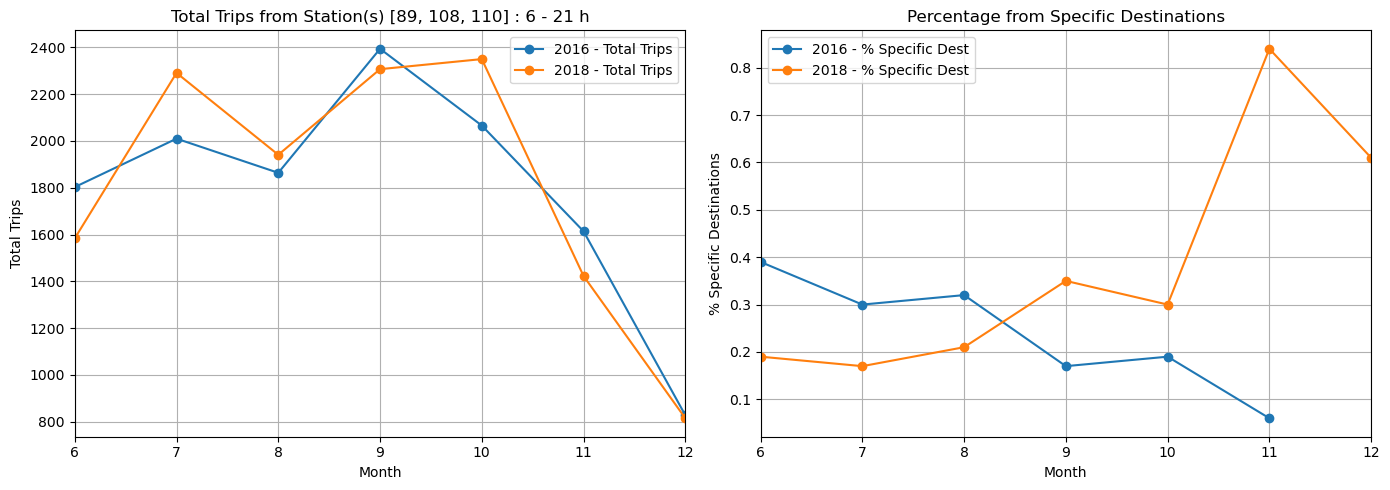

In [94]:
data_trip = target_trip_count
years = [2016, 2018]

tn = [89,108,110]

# dest = [181,104,89,108,110] #side left
dest = [109] #side right

# direction = 'depart'
direction = 'arrive'

time_span = range(6, 22)
analyze_trip_data(data_trip, tn, years, dest, direction , time_span)

## Duration Analysis

In [95]:
combined_data = cd

In [96]:
def aggregate_time_groups(data, hours, months, year):
    start_hour = min(hours)
    end_hour = max(hours)
    filtered_data = data[
        (data['hour'] >= start_hour) &
        (data['hour'] < end_hour) &
        (data['month'].isin(months)) &
        (data['year'] == year)
    ]
    aggregated_data = filtered_data.groupby(['start station id', 'end station id'])['median duration'].median().reset_index()
    return filtered_data, aggregated_data

def get_common_trips(data_after, data_before):
    common_trips = pd.merge(data_after, data_before, on=['start station id', 'end station id'], suffixes=('_after', '_before'))
    return common_trips.drop_duplicates()

def compare_trip_durations(common_trips):
    common_trips['duration_diff'] = common_trips['median duration_after'] - common_trips['median duration_before']
    common_trips['%_diff'] =  common_trips['duration_diff']/common_trips['median duration_before']*100
    return common_trips[['start station id', 'end station id', 'median duration_after', 'median duration_before', 'duration_diff', '%_diff']].drop_duplicates()


In [97]:
def process_data_for_years(data, year_hours, year_months, years):
    
    year_data = {}
    
    for year in years:
        hours = year_hours[year]
        months = year_months[year]
        _,year_data[year] = aggregate_time_groups(data, hours, months, year)

    for i in range(len(years) - 1):
        year_before = years[i]
        year_after = years[i+1]
        
        common_data = get_common_trips(year_data[year_after], year_data[year_before])
        comparison_data = compare_trip_durations(common_data)
        
        print(f"Duration difference between {year_after} and {year_before}:", comparison_data['duration_diff'].median(), "secs")
        print(f"Percent duration difference between {year_after} and {year_before}:", np.round(comparison_data['%_diff'].median(), 2), "%")
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        ax1.hist(comparison_data['duration_diff'], bins=10, edgecolor='black', color='lightblue', alpha=0.7)
        ax1.set_title(f'Trip Duration Differences ({year_before} vs {year_after})', fontsize=14)
        ax1.set_xlabel('Duration Difference (seconds)', fontsize=12)
        ax1.set_ylabel('Frequency', fontsize=12)
        ax1.grid(True)
        
        ax2.hist(comparison_data['%_diff'], bins=10, edgecolor='black', color='lightblue', alpha=0.7)
        ax2.set_title(f'% Differences ({year_before} vs {year_after})', fontsize=14)
        ax2.set_xlabel('%', fontsize=12)
        ax2.set_ylabel('Frequency', fontsize=12)
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()
        return common_data , comparison_data

Duration difference between 2018 and 2016: -22.75 secs
Percent duration difference between 2018 and 2016: -4.11 %


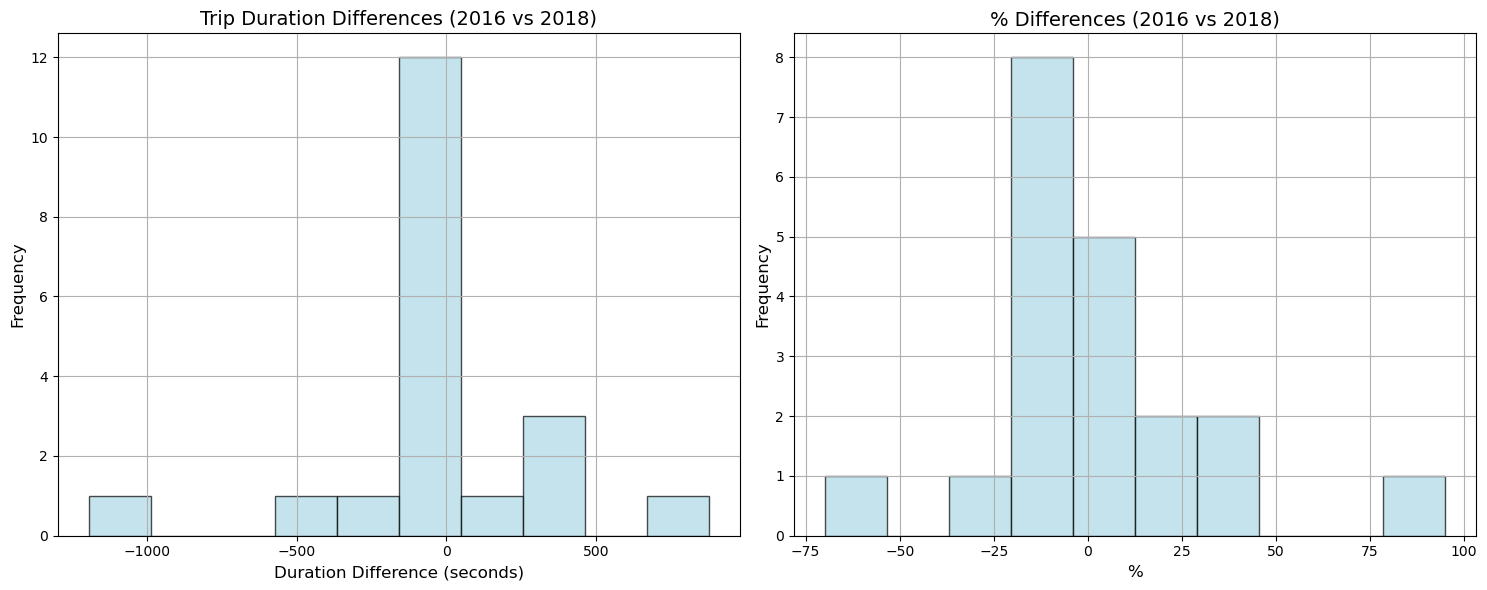

In [98]:
year_hours = {2016: range(6, 12), 2018: range(6, 12)}
year_months = {2016: range(9,12), 2018: range(9,12)}
years = [2016, 2018]

_, comp_morn_1618 = process_data_for_years(combined_data, year_hours, year_months, years)

In [107]:
def plot_duration_histograms(data, param_sets, figsize=(7, 4)):
    for set_name, params in param_sets.items():
        plt.figure(figsize=figsize)
        max_duration = 0
        min_duration = 3
        a = 0
        for year, color in params['years']:
            for time_range in params['hour_ranges']:
                filtered_data = data[(data['start station id'].isin(params['start_node'])) & 
                                     (data['end station id'].isin(params['end_node']))].copy()
                
                filtered_data['median duration'] = filtered_data['median duration'].astype(float) / 60
                aggregated_data, _ = aggregate_time_groups(filtered_data, time_range, params['months'], year)

                if len(aggregated_data)==0:
                    continue

                max_duration = max(max_duration, max(np.round(aggregated_data['median duration'])))
                min_duration = min(min_duration, min(np.round(aggregated_data['median duration'])))

                plt.hist(np.round(aggregated_data['median duration']), bins=params['bins_range'], edgecolor='black', 
                         color=color, alpha=0.5, label=f"{year}, mon: {min(params['months'])} - {max(params['months'])}, ({time_range.start}-{time_range.stop}h)", align='left')

                a = -a +  np.median(aggregated_data['median duration'])

        print(f"The duration difference : {np.round(a,2)} mins")
        plt.title(f"Trip Durations Distribution from {params['start_node']} to {params['end_node']} ")
        plt.xlabel('Duration (minutes)')
        plt.ylabel('Frequency')
        plt.legend()
        plt.xticks(params['bins_range'])
        plt.xlim(min_duration,  max_duration+1)
        plt.show()

The duration difference : 6.73 mins


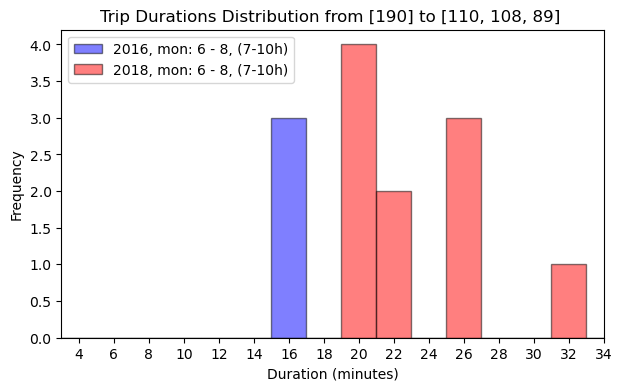

The duration difference : 13.98 mins


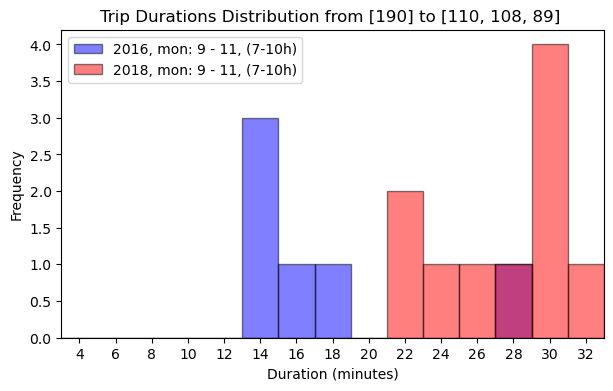

In [112]:
param_sets = {
    'set1': {
        'start_node': [190],
        'end_node': [110, 108, 89],
        'years': [(2016, 'blue'), (2018, 'red')],
        'hour_ranges': [range(7, 10)],  # Different time ranges
        'months': [6, 7, 8],
        'bins_range': range(2, 45, 2)
    },
    'set2': {
        'start_node': [190],
        'end_node': [110, 108, 89],
        'years': [(2016, 'blue'), (2018, 'red')],
        'hour_ranges': [range(7, 10)],  # Different time ranges
        'months': [9, 10, 11],
        'bins_range': range(2, 45, 2)
    }
}

plot_duration_histograms(data=combined_data, param_sets=param_sets)

## Community Analysis

In [117]:
def normalize_weights(G):
    total_trips = sum([data['weight'] for _, _, data in G.edges(data=True)])
    for u, v, data in G.edges(data=True):
        data['weight'] /= total_trips
    return G

In [217]:
def generate_community(years, months, hours, zoom_size, full=False):
    
    maps = {}
    com_col_prev = None
    mod_df = pd.DataFrame()
    

    for yy in years:
        for mm in months:
            bsn = download_and_unzip(int(yy), int(mm))

            for hour in hours:

                data_afr, trip_counts_afr, stations_loc_afr = initial_cleaning(month=mm, year=yy, start_hour=hour, end_hour=hour+1, bsn_full=bsn)
                # Eliminate stations that are not in June 2016
                data_afr, trip_counts_afr, stations_loc_afr, new_stations_afr = elim_stations(data_16_6, trip_counts_16_6, stations_loc_16_6, data_afr, trip_counts_afr, stations_loc_afr)
                
                if full==True:
                    closest_stations =  np.asarray(stations_loc_afr['station id'])

                else:
                    # Find the closest stations
                    # closest_stations = list(set(
                    #     the_spots(np.array(cam_str[0]), 10000, stations_loc_afr) +
                    #     the_spots(np.array(cam_str[-1]), 10000, stations_loc_afr) +
                    #     the_spots(np.array(ox_str[0]), 10000, stations_loc_afr) +
                    #     the_spots(np.array(ox_str[-1]), 10000, stations_loc_afr)
                    # ))
                    
                    station_ids = [88,95,225,90,182,190,109,181,104,89,108,110]
                    station_rows = stations_loc_afr[stations_loc_afr['station id'].isin(station_ids)]
                    coordinates = station_rows.apply(lambda row: [row['latitude'], row['longitude']], axis=1).tolist()
    
                    all_spots = []
                    num_neighbour = 5
                    for coord in coordinates:
                        all_spots += the_spots(np.array(coord), num_neighbour, stations_loc_afr)
                      
                    closest_stations = list(set(all_spots))
                    closest_stations = [num for num in closest_stations if num not in [78, 116, 79,6]]

                # Prepare graph data
                partial_df_afr, loc_partial_afr, data_afr, partial_nw_afr = partial_graph_data(closest_stations, trip_counts_afr, stations_loc_afr, data_afr)
    
                # Compute adjacency matrix and validate trip counts
                adj_as = pd.DataFrame(nx.adjacency_matrix(partial_nw_afr).todense().astype(int), 
                                      index=partial_nw_afr.nodes(), columns=partial_nw_afr.nodes())
                if adj_as.sum().sum() != np.sum(partial_df_afr['trip_count']):
                    continue

                # calculate centrality
                net_norm = normalize_weights(partial_nw_afr)
                central = nx.betweenness_centrality(net_norm, weight='weight')
                top_central = sorted(central.items(), key=lambda x: x[1], reverse=True)[:1]
                

                # Community detection and plotting
                bmod18, bres18, commun18 = com_finder(partial_nw_afr, resolutions_range=[1], plot=False)
                if full:
                    mod_entry = pd.DataFrame({'mod': [bmod18], 'hour': [hour], 'month': [mm], 'year': [yy]})
                    mod_df = pd.concat([mod_df, mod_entry], ignore_index=True)
                
                if com_col_prev is None:
                    d1 = create_community_color_df(commun18, colors)
                    d1 = pd.merge(d1, loc_partial_afr, right_on='station id', left_on='Node', how='inner')
                    centroids = calculate_center_of_mass(d1)
                    color_mapping = assign_colors_based_on_proximity(centroids, anchors, all_colors)
                    d1['Color'] = d1['Community'].map(color_mapping)
                    comm_col_afr, map_html = plot_community(d1, loc_partial_afr, zoom_size, month=mm, year=yy, time=hour, central_node = top_central[0][0])
                else:
                    com_col_now = create_community_color_df(commun18, colors)
                    com_col_now = pd.merge(com_col_now, loc_partial_afr, right_on='station id', left_on='Node', how='inner')
                    ss = enhanced_color_assignment(com_col_prev, com_col_now, update_available_colors(com_col_prev), anchors)
                    comm_col_afr, map_html = plot_community(ss, loc_partial_afr, zoom_size, month=mm, year=yy, time=hour, central_node = top_central[0][0])
                
                com_col_prev = comm_col_afr


                # Save map
                result_folder = os.path.join("result", f"{yy}_{mm}")
                os.makedirs(result_folder, exist_ok=True)
                if full==True:
                    map_file = os.path.join(result_folder, f"map_hour_{hour}_mon_{mm}_year_{yy}_full.html")
                else:
                    map_file = os.path.join(result_folder, f"map_hour_{hour}_mon_{mm}_year_{yy}_partial.html")
                map_html.save(map_file)
                maps[(yy, mm, hour)] = map_file

    return maps,partial_nw_afr,commun18, mod_df

In [218]:
data_16_6, trip_counts_16_6, stations_loc_16_6 = initial_cleaning (month = 6, year = 2016, start_hour = 1 , end_hour = 23)

201606-hubway-tripdata.zip already exists.


In [224]:
years = [2016,2018]
months = range(6,13)
hours = range(6,23)  
zoom_size = 14

maps,nw,cc,mod_df = generate_community(years, months, hours, zoom_size, full=False)

201606-hubway-tripdata.zip already exists.
201607-hubway-tripdata.zip already exists.
201608-hubway-tripdata.zip already exists.
201609-hubway-tripdata.zip already exists.
201610-hubway-tripdata.zip already exists.
201611-hubway-tripdata.zip already exists.
201612-hubway-tripdata.zip already exists.
201806-bluebikes-tripdata.zip already exists.
201807-bluebikes-tripdata.zip already exists.
201808-bluebikes-tripdata.zip already exists.
201809-bluebikes-tripdata.zip already exists.
201810-bluebikes-tripdata.zip already exists.
201811-bluebikes-tripdata.zip already exists.
201812-bluebikes-tripdata.zip already exists.


In [225]:
def generate_map(hour, mon, yy, map_type):
    valid_map_types = {"arrive", "depart", "full", "partial"}
    
    if map_type not in valid_map_types:
        raise ValueError(f"Invalid map type '{map_type}'. Valid options are {valid_map_types}.")

    # Heatmap for 'arrive' or 'depart'
    if map_type in {"arrive", "depart"}:
        map_file = os.path.join("result", f"{yy}_{mon}", f"map_hour_{hour}_mon_{mon}_year_{yy}_{map_type}.html")
    # Community - Full or Part
    else:
        map_file = os.path.join("result", f"{yy}_{mon}", f"map_hour_{hour}_mon_{mon}_year_{yy}_{map_type}.html")
    
    # Determine the map file to display
    map_file_to_display = map_file if os.path.exists(map_file) else ""

    if os.path.exists(map_file_to_display):
        with map_output:
            clear_output(wait=True)
            display(IFrame(map_file_to_display, width='100%', height='500px'))
    else:
        print(f"Map file for {yy}-{mon}-{hour} does not exist in '{map_type}' form.")

In [226]:
# Output widgets for controls and the map display
controls_output = widgets.Output()
map_output = widgets.Output()

# Define the range for hour, month, and year
hour_slider = widgets.IntSlider(min=6, max=22, step=1, value=8, description='Hour:')
month_slider = widgets.IntSlider(min=6, max=11, step=1, value=9, description='Month:')
year_slider = widgets.IntSlider(min=2016, max=2018, step=2, value=2018, description='Year:')
map_type_dropdown = widgets.Dropdown(options=['arrive', 'depart', 'full', 'partial'], value='full', description='Map Type:')

# Function to update the map based on widget values
def update_map(change):
    generate_map(hour_slider.value, month_slider.value, year_slider.value, map_type_dropdown.value)

# Add observers to update the map when any of the widget values change
hour_slider.observe(update_map, names='value')
month_slider.observe(update_map, names='value')
year_slider.observe(update_map, names='value')
map_type_dropdown.observe(update_map, names='value')

# Display the controls in the controls_output widget
with controls_output:
    display(hour_slider, month_slider, year_slider, map_type_dropdown)

# Initial display setup
display(controls_output, map_output)
generate_map(hour_slider.value, month_slider.value, year_slider.value, map_type_dropdown.value)

Output()

Output()

### Grafik Modulariti

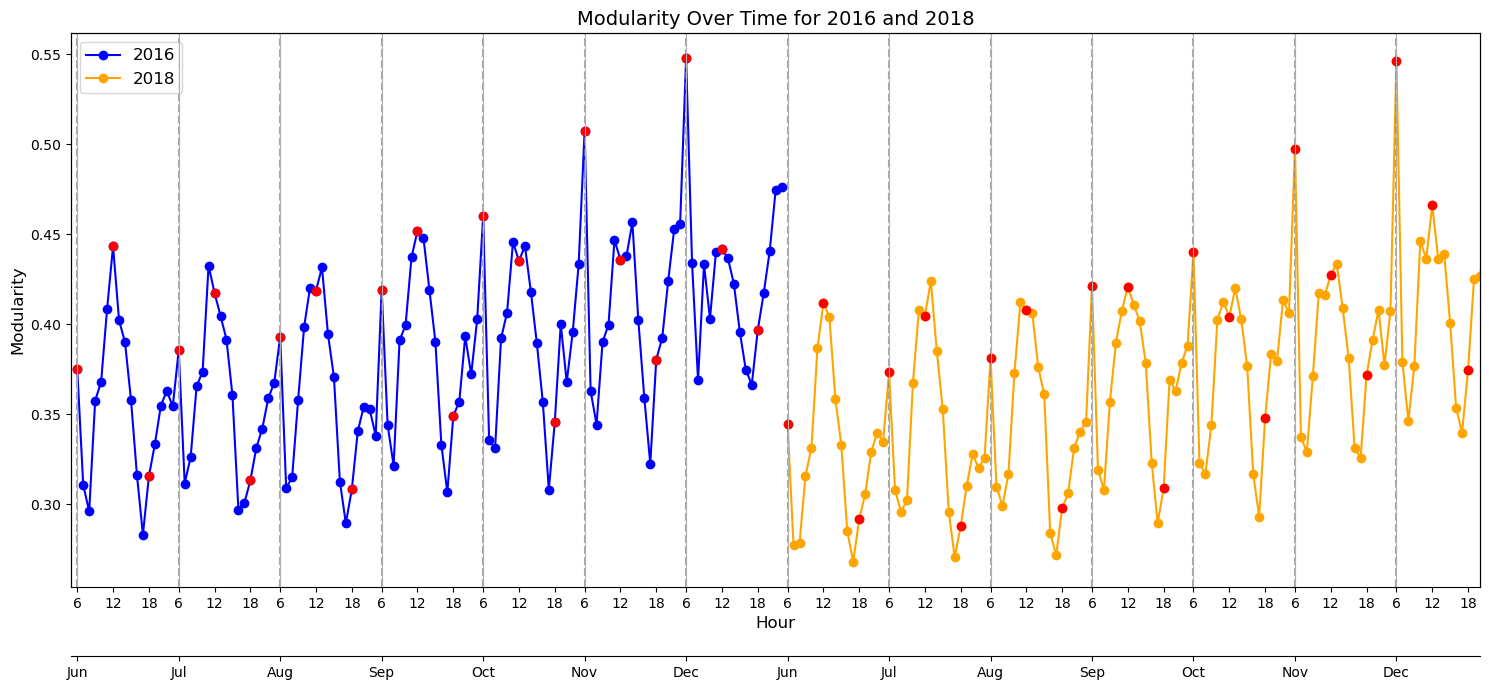

In [207]:
df_2016 = mod_df[mod_df['year'] == 2016]
df_2018 = mod_df[mod_df['year'] == 2018]

fig, ax = plt.subplots(figsize=(15, 7))

ax.plot(df_2016.index, df_2016['mod'], label='2016', marker='o', linestyle='-', color='blue')
ax.plot(df_2018.index, df_2018['mod'], label='2018', marker='o', linestyle='-', color='orange')

x_ticks_hours = []
x_ticks_months = []
x_labels_hours = []
x_labels_months = []

# Month mapping to shortened format
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

months_seen = []
for index, row in mod_df.iterrows():
    if row['hour'] in [6, 12, 18]:
        x_ticks_hours.append(index)
        x_labels_hours.append(f"{int(row['hour'])}")
    if row['month'] not in months_seen:
        months_seen.append(row['month'])
        x_ticks_months.append(index)
        x_labels_months.append(month_map[row['month']])

ax.set_xticks(x_ticks_hours)
ax.set_xticklabels(x_labels_hours, rotation=0, ha='center', fontsize=10)
ax.set_xlim([min(x_ticks_hours)-1, max(x_ticks_hours)+2])

# Secondary x-axis for the months
ax2 = ax.twiny()
x_ticks_months_extended = x_ticks_months + [index + len(df_2016) for index in x_ticks_months]
x_labels_months_extended = x_labels_months + x_labels_months

ax2.set_xticks(x_ticks_months_extended)
ax2.set_xticklabels(x_labels_months_extended, fontsize=12, color='gray')
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 50))  
ax2.set_xlim(ax.get_xlim())

# Veertical lines for month separation
for month_tick in x_ticks_months_extended:
    ax.axvline(x=month_tick, color='gray', linestyle='--', alpha=0.7)

# Special hours have red dots
special_hours = [6, 12, 18]
for hour in special_hours:
    special_df_2016 = df_2016[df_2016['hour'] == hour]
    special_df_2018 = df_2018[df_2018['hour'] == hour]
    ax.plot(special_df_2016.index, special_df_2016['mod'], 'ro')
    ax.plot(special_df_2018.index, special_df_2018['mod'], 'ro')

ax.set_xlabel('Hour', fontsize=12)
ax.set_ylabel('Modularity', fontsize=12)
ax.set_title('Modularity Over Time for 2016 and 2018', fontsize=14)
ax.legend(fontsize=12)

plt.tight_layout()
plt.grid()
plt.show()


### Saving to Image, Video and GIF

In [ ]:
hti = Html2Image()

for hour, map_file in maps.items():
    img_path = f"map_{hour}.png"
    hti.screenshot(html_file=map_file, save_as=img_path)
    maps[hour] = img_path 

In [ ]:
import imageio.v2 as imageio
filenames = [maps[hour] for hour in sorted(maps.keys())]

images = [imageio.imread(filename) for filename in filenames]
duration_set = 500 
imageio.mimsave('maps_animation9_after.gif', images, duration=duration_set)

In [ ]:
import imageio
# writer = imageio.get_writer('maps_animation9_after.mp4', fps=2, macro_block_size=1)
writer = imageio.get_writer('ori.mp4', fps=2, macro_block_size=1)

for image in images:
    writer.append_data(image)
writer.close()

## Experiment Bench

In [225]:
def normalize_weights(G):
    total_trips = sum([data['weight'] for _, _, data in G.edges(data=True)])
    for u, v, data in G.edges(data=True):
        data['weight'] /= total_trips
    return G
central = nx.betweenness_centrality(G_2020, weight='weight')
top_central = sorted(central.items(), key=lambda x: x[1], reverse=True)[:1]
top_central[0][0]

68.0

In [259]:
def normalize_weights(G):
    total_trips = sum([data['weight'] for _, _, data in G.edges(data=True)])
    for u, v, data in G.edges(data=True):
        data['weight'] /= total_trips
    return G

# Normalize the weights
G_2020 = normalize_weights(nw16)
G_2021 = normalize_weights(nw18)

# Compute betweenness centrality for each year
betweenness_centrality_2020 = nx.betweenness_centrality(G_2020, weight='weight')
betweenness_centrality_2021 = nx.betweenness_centrality(G_2021, weight='weight')

# Get the top 5 nodes by betweenness centrality for each year
top_5_betweenness_2020 = sorted(betweenness_centrality_2020.items(), key=lambda x: x[1], reverse=True)[:15]
top_5_betweenness_2021 = sorted(betweenness_centrality_2021.items(), key=lambda x: x[1], reverse=True)[:15]

# Display the top 5 nodes
top_5_betweenness_2020_df = pd.DataFrame(top_5_betweenness_2020, columns=['Node', 'Betweenness Centrality 2020'])
top_5_betweenness_2021_df = pd.DataFrame(top_5_betweenness_2021, columns=['Node', 'Betweenness Centrality 2021'])

print("Top 5 Nodes by Betweenness Centrality in 2020:")
print(top_5_betweenness_2020_df)

print("\nTop 5 Nodes by Betweenness Centrality in 2021:")
print(top_5_betweenness_2021_df)


Top 5 Nodes by Betweenness Centrality in 2020:
     Node  Betweenness Centrality 2020
0    90.0                     0.330128
1   190.0                     0.304487
2   110.0                     0.259081
3    88.0                     0.163996
4   116.0                     0.157051
5    89.0                     0.152244
6   108.0                     0.082265
7    38.0                     0.070513
8    95.0                     0.028846
9    79.0                     0.025641
10   84.0                     0.000000
11  109.0                     0.000000
12   78.0                     0.000000
13  195.0                     0.000000

Top 5 Nodes by Betweenness Centrality in 2021:
     Node  Betweenness Centrality 2021
0    90.0                     0.337606
1   108.0                     0.286811
2    88.0                     0.244025
3    78.0                     0.160256
4    84.0                     0.088423
5   195.0                     0.086538
6   190.0                     0.077457
7    89.

In [248]:
import networkx as nx

# Example graph and communities
G = nw18
communities = cc18

# Create a node to community map
node_to_community = {}
for index, community in enumerate(communities):
    for node in community:
        node_to_community[node] = index

# Function to find border nodes
def find_border_nodes(graph, node_to_community):
    border_nodes = set()
    for u, v in graph.edges():
        if node_to_community[u] != node_to_community[v]:
            border_nodes.add(u)
            border_nodes.add(v)
    return border_nodes

# Get border nodes
border_nodes18 = find_border_nodes(G, node_to_community)

# Output border nodes
print("Border Nodes:", border_nodes18)


Border Nodes: {6.0, 108.0, 109.0, 78.0, 110.0, 79.0, 84.0, 116.0, 88.0, 89.0, 90.0, 190.0, 95.0}


In [189]:
G = nw16
communities = cc16

# Create a node to community map
node_to_community = {}
for index, community in enumerate(communities):
    for node in community:
        node_to_community[node] = index

# Function to find border nodes
def find_border_nodes(graph, node_to_community):
    border_nodes = set()
    for u, v in graph.edges():
        if node_to_community[u] != node_to_community[v]:
            border_nodes.add(u)
            border_nodes.add(v)
    return border_nodes

# Get border nodes
border_nodes16 = find_border_nodes(G, node_to_community)

# Output border nodes
print("Border Nodes:", border_nodes16)

Border Nodes: {6.0, 143.0, 38.0, 171.0, 190.0, 195.0, 73.0, 74.0, 78.0, 79.0, 84.0, 88.0, 89.0, 90.0, 91.0, 95.0, 108.0, 109.0, 110.0, 116.0}


In [190]:
len(border_nodes18)-len(border_nodes16)

1

In [193]:
len(border_nodes16)

20

In [196]:
num_edges = G.number_of_nodes()
num_edges

21